#**본 코드는 하위 자료를 참조하여 구성하였습니다**


1. 2020 전산언어학 겨울학교, 고려대학교 언어정보연구소 계산의미론연구실

2. https://www.kaggle.com/samarthsarin/bert-with-transformers

3. https://mccormickml.com/2019/07/22/BERT-fine-tuning/



#**Colab설정하기**

##상단의 [수정 -> 노트설정 -> 하드웨어 가속기 -> GPU -> 저장] 

#**드라이브 마운트** 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<br>
<br>

# **개인 드라이브 설정에 맞추어서 디렉토리 변경하기**

In [2]:
cd /content/drive/My Drive/Colab Notebooks/2020_01_BERT_sentiment_analysis

/content/drive/My Drive/Colab Notebooks/2020_01_BERT_sentiment_analysis


<br>
<br>

# **준비 사항**

In [3]:
!pip install transformers

     |████████████████████████████████| 481kB 3.4MB/s 
     |████████████████████████████████| 1.0MB 16.2MB/s 
     |████████████████████████████████| 3.1MB 22.6MB/s 
     |████████████████████████████████| 870kB 29.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=daca94033191378876b3384434836beee3e00c97922572a2457598e5c5e24885
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [4]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

Using TensorFlow backend.


<br>
<br>

# **데이터 로드**

In [5]:
# 판다스로 데이터 로드 
train = pd.read_pickle("train_data_200131.pkl")
test = pd.read_pickle("test_data_200131.pkl")

print(train.shape)
print(test.shape)

(1000000, 7)
(400000, 7)


In [6]:
train.iloc[:2]

,Sentiment,Date,Blank,SentimentText,TrimText_lemma,TrimText_lemma_len,TrimText_lemma_join
0,0,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,is upset that he can't update his Facebook by ...,"[upset, not, update, facebook, texting, might,...",12,upset not update facebook texting might cry re...
1,0,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,@Kenichan I dived many times for the ball. Man...,"[dive, many, time, ball, manage, save, rest, g...",9,dive many time ball manage save rest go bound


In [0]:
# 분석할 문장 추출 
sentences = train['TrimText_lemma_join']

In [30]:
type(sentences)

list

In [28]:
train['TrimText_lemma_join'][0]

'upset not update facebook texting might cry result school today also blah'

In [43]:
# 3.2 BERT 딥러닝 학습을 위한 데이터 형태 변형 
# 3.2.1 식별자 삽입
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[0]

'[CLS] upset not update facebook texting might cry result school today also blah [SEP]'

In [44]:
type(sentences)

list

In [0]:
# Sentiment 칼럼의 데이터는 0 또는 1로 되어있는데 저장된 파일을 바로 부르게되면 데이터 타입이 intrk 아닌 object 타입으로 
# 불러지게 된다. 그렇게 때문에 object 타입의 0 또는 1을 int 타입의 데이터로 변형해주어야 한다. 

In [11]:
train['Sentiment'].dtype

dtype('O')

In [0]:
train['Sentiment'] = pd.to_numeric(train['Sentiment'])

In [13]:
train['Sentiment'].dtype

dtype('int64')

In [0]:
test['Sentiment'] = pd.to_numeric(test['Sentiment'])

In [15]:
# 라벨 추출
labels = train['Sentiment'].values
labels

array([0, 0, 0, ..., 1, 1, 1])

In [0]:
# 전체 데이터를 학습시킬시 학습 시간이 오래 걸려서 데이터의 일부만 학습시킴
# 전체 데이터 학습을 위해서는 해당 코드를 실행하지 않으면됨 

sentences_sample = train['TrimText_lemma_join'][:50000].append(train['TrimText_lemma_join'][-50000:])
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences_sample]

label_sample = train['Sentiment'][:50000].append(train['Sentiment'][-50000:])
labels = label_sample.values

In [52]:
# 3.2.2 Wordpiece tokenizer
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (tokenized_texts[0])


['[CLS]', 'upset', 'not', 'update', 'face', '##book', 'text', '##ing', 'might', 'c', '##ry', 'result', 'school', 'today', 'also', 'bl', '##ah', '[SEP]']


In [53]:
print('Max sentence length: ', max([len(tokenized_text) for tokenized_text in tokenized_texts]))

Max sentence length:  47


In [54]:
#3.2.3 임베딩 (embedding)
# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 3.2.4 문장의 길이 맞추기 및 패딩(padding)

# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 50

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids[0]

array([  101, 96213, 10472, 35896, 13295, 24777, 15541, 10230, 20970,
         171, 10908, 14493, 11393, 18745, 10379, 21484, 12257,   102,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [55]:
# 3.2.5 어텐션 마스크(attention mask)
# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [56]:
# 3.2.6 데이터 분리
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2018, 
                                                                                    test_size=0.2)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2018, 
                                                       test_size=0.2)

#3.2.7 데이터 파이토치 형식으로 변환 
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([  101, 12796, 10874, 26591, 12174, 11850, 33741, 20395,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
tensor(1)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([  101, 10104, 21146, 27874, 19540, 17835, 17113, 18121, 10174, 28552,
        10354, 23282, 10472, 12504, 14932, 17038, 15102,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0

In [0]:
# 배치 사이즈

batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# **모델 생성**

In [58]:
# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [59]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [60]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [0]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 3 # epochs 조절하기 

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 학습률을 조금씩 감소시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# **모델 학습**

In [0]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [64]:
import os
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/2020_01_BERT_sentiment_analysis'

In [0]:
PATH = os.getcwd() + '/bert_checkpoint'

In [65]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 학습이 끝난 후, 각 에폭당 loss 값과 정확도 확인하기 위한 리스트 만들기 
loss_values = []
eval_acc_total = []

# 그래디언트 초기화
model.zero_grad()

train_losses, val_losses = [], []

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        #elif step % 10000 == 0 and not step == 0:
            
          #torch.save(model.state_dict(), PATH+'train_model_step{}.pth'.format(step+10000))
          #torch.save(model, PATH+'train_full_model_step{}.pth'.format(step+10000))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]
        #print(loss)

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

        

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)   

    # 로스값 저장
    loss_values.append(avg_train_loss)

      
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    # 정확도 저장
    eval_acc_total.append("{0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch   100  of  2,500.    Elapsed: 0:00:33.
  Batch   200  of  2,500.    Elapsed: 0:01:07.
  Batch   300  of  2,500.    Elapsed: 0:01:42.
  Batch   400  of  2,500.    Elapsed: 0:02:17.
  Batch   500  of  2,500.    Elapsed: 0:02:52.
  Batch   600  of  2,500.    Elapsed: 0:03:27.
  Batch   700  of  2,500.    Elapsed: 0:04:02.
  Batch   800  of  2,500.    Elapsed: 0:04:37.
  Batch   900  of  2,500.    Elapsed: 0:05:12.
  Batch 1,000  of  2,500.    Elapsed: 0:05:47.
  Batch 1,100  of  2,500.    Elapsed: 0:06:22.
  Batch 1,200  of  2,500.    Elapsed: 0:06:57.
  Batch 1,300  of  2,500.    Elapsed: 0:07:32.
  Batch 1,400  of  2,500.    Elapsed: 0:08:07.
  Batch 1,500  of  2,500.    Elapsed: 0:08:42.
  Batch 1,600  of  2,500.    Elapsed: 0:09:17.
  Batch 1,700  of  2,500.    Elapsed: 0:09:52.
  Batch 1,800  of  2,500.    Elapsed: 0:10:27.
  Batch 1,900  of  2,500.    Elapsed: 0:11:02.
  Batch 2,000  of  2,500.    Elapsed: 0:11:37.
  Batch 2,100  of

In [66]:
eval_acc_total

['0.79', '0.79', '0.79']

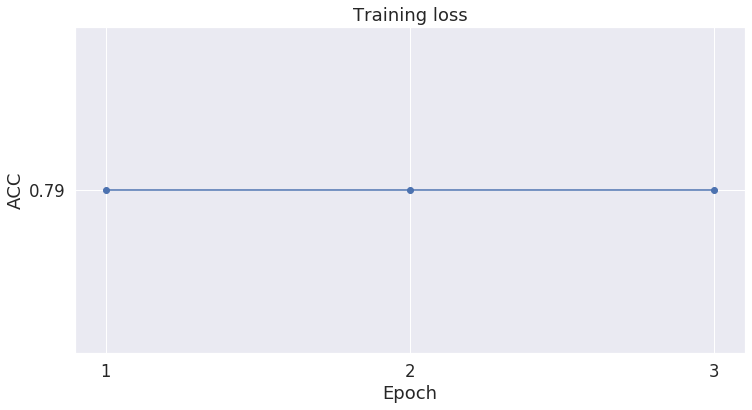

In [83]:
# 에폭당 정확도 확인 : 전체 데이터를 에폭수 2개로해서 학습 시켰을 때 첫 번째 에폭에서는 79%, 두 번째 에폭에서는 82%의 정확도를 얻었다
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(([1,2,3]),eval_acc_total, 'b-o')
plt.xticks([1,2,3])

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("ACC")

plt.show()

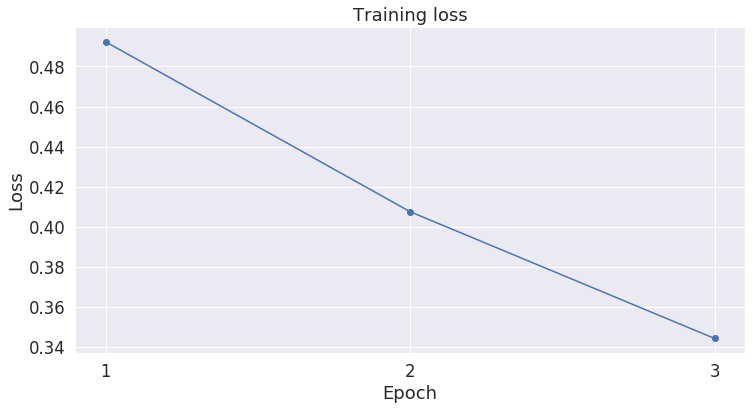

In [87]:
# 에폭당 로스값 확인
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot([1,2,3],loss_values, 'b-o')
plt.xticks([1,2,3])

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [0]:
# 학습 시킨 모델 저장
torch.save(model, 'bert_model_02_07.pt')

# **테스트셋**

In [0]:
# 저장된 모델 불러오기
load_model = torch.load('bert_model_02_07.pt')

In [71]:
test.iloc[:2]

,Sentiment,Date,Blank,SentimentText,TrimText_lemma,TrimText_lemma_len,TrimText_lemma_join
500096,0,Mon Jun 15 19:15:59 PDT 2009,NO_QUERY,@HotBoyBruce jus. Am,[jus],1,jus
500097,0,Mon Jun 15 19:16:00 PDT 2009,NO_QUERY,"@TheMandyMoore awww, you poor thing take it e...","[aww, poor, thing, take, easy]",5,aww poor thing take easy


In [0]:
# 리뷰 문장 추출
sentences = test['TrimText_lemma_join']

In [73]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] jus [SEP]',
 '[CLS] aww poor thing take easy [SEP]',
 '[CLS] love mcfly much [SEP]',
 '[CLS] come back chillin room enjoy last hour vacation buaahh [SEP]',
 '[CLS] bed school home study exam [SEP]',
 '[CLS] love password [SEP]',
 '[CLS] aw hon sorry lose two dog since january not close together feel sadness hug [SEP]',
 '[CLS] even run not productive could not complete route yesterday end day go bed [SEP]',
 '[CLS] yeahh shoot [SEP]',
 '[CLS] miss deal [SEP]']

In [74]:
# 라벨 추출
labels = test['Sentiment'].values
labels

array([0, 0, 0, ..., 1, 1, 1])

In [75]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

[CLS] jus [SEP]
['[CLS]', 'ju', '##s', '[SEP]']


In [76]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 50

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([  101, 23005, 10107,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [77]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [78]:
# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([  101, 23005, 10107,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
tensor(0)
tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [0]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [80]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
load_model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 1000 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = load_model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

  Batch 1,000  of  12,500.    Elapsed: 0:01:40.
  Batch 2,000  of  12,500.    Elapsed: 0:03:19.
  Batch 3,000  of  12,500.    Elapsed: 0:04:58.
  Batch 4,000  of  12,500.    Elapsed: 0:06:36.
  Batch 5,000  of  12,500.    Elapsed: 0:08:15.
  Batch 6,000  of  12,500.    Elapsed: 0:09:54.
  Batch 7,000  of  12,500.    Elapsed: 0:11:33.
  Batch 8,000  of  12,500.    Elapsed: 0:13:12.
  Batch 9,000  of  12,500.    Elapsed: 0:14:52.
  Batch 10,000  of  12,500.    Elapsed: 0:16:31.
  Batch 11,000  of  12,500.    Elapsed: 0:18:10.
  Batch 12,000  of  12,500.    Elapsed: 0:19:50.

Accuracy: 0.79
Test took: 0:20:40
